In [1]:
import sys
sys.path.append('../code/')

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf

from preprocessing_utils import preprocess_df
from plot_utils import plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels
from metrics import mean_absolute_error, rmse, rss, r2_score, durbin_watson

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Upload data

In [2]:
ts = pd.read_csv('../data/US1.NVDA_200101_210215.csv', delimiter=';')
ts = preprocess_df(ts)
ts

,ticker,per,date,time,open,high,low,close,vol,Nclose
0,US1.NVDA,D,2020-01-02,0,238.85,239.88,236.73,239.79,303428,0.392886
1,US1.NVDA,D,2020-01-03,0,234.65,237.81,234.17,236.37,268936,0.387282
2,US1.NVDA,D,2020-01-06,0,232.21,237.25,231.52,237.07,432624,0.388429
3,US1.NVDA,D,2020-01-07,0,238.03,241.76,236.39,239.83,576787,0.392951
4,US1.NVDA,D,2020-01-08,0,239.65,242.04,238.15,240.42,540373,0.393918
...,...,...,...,...,...,...,...,...,...,...
275,US1.NVDA,D,2021-02-08,0,549.96,578.93,549.96,577.70,316219,0.946537
276,US1.NVDA,D,2021-02-09,0,574.02,583.00,568.90,570.35,142242,0.934494
277,US1.NVDA,D,2021-02-10,0,579.02,596.20,574.45,590.72,320581,0.967870
278,US1.NVDA,D,2021-02-11,0,599.50,610.89,597.61,610.33,268265,1.000000


# Observation

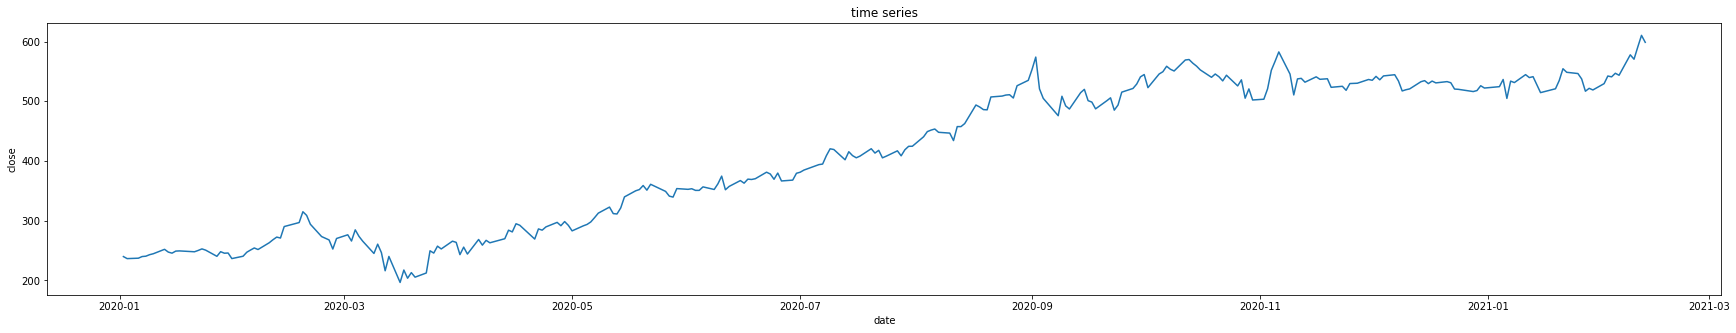

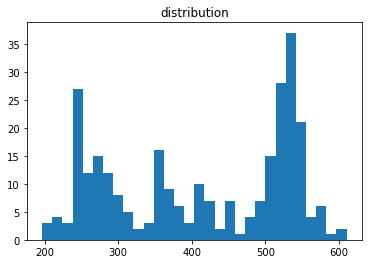

In [3]:
plot_store_charts(ts)

# Checks for Stationarity

In [4]:
test_results = {}
test_results.update(run_stat_test(ts['close'], adfuller))
test_results.update(run_stat_test(ts['close'], kpss, 3))

pd.Series(test_results)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


adfuller_statistics           -0.530404
adfuller_p_value               0.885946
adfuller_critical_value_1%    -3.454355
adfuller_critical_value_5%    -2.872108
adfuller_critical_value_10%   -2.572401
kpss_statistics                1.673479
kpss_p_value                   0.010000
kpss_critical_value_10%        0.347000
kpss_critical_value_5%         0.463000
kpss_critical_value_2.5%       0.574000
kpss_critical_value_1%         0.739000
dtype: float64

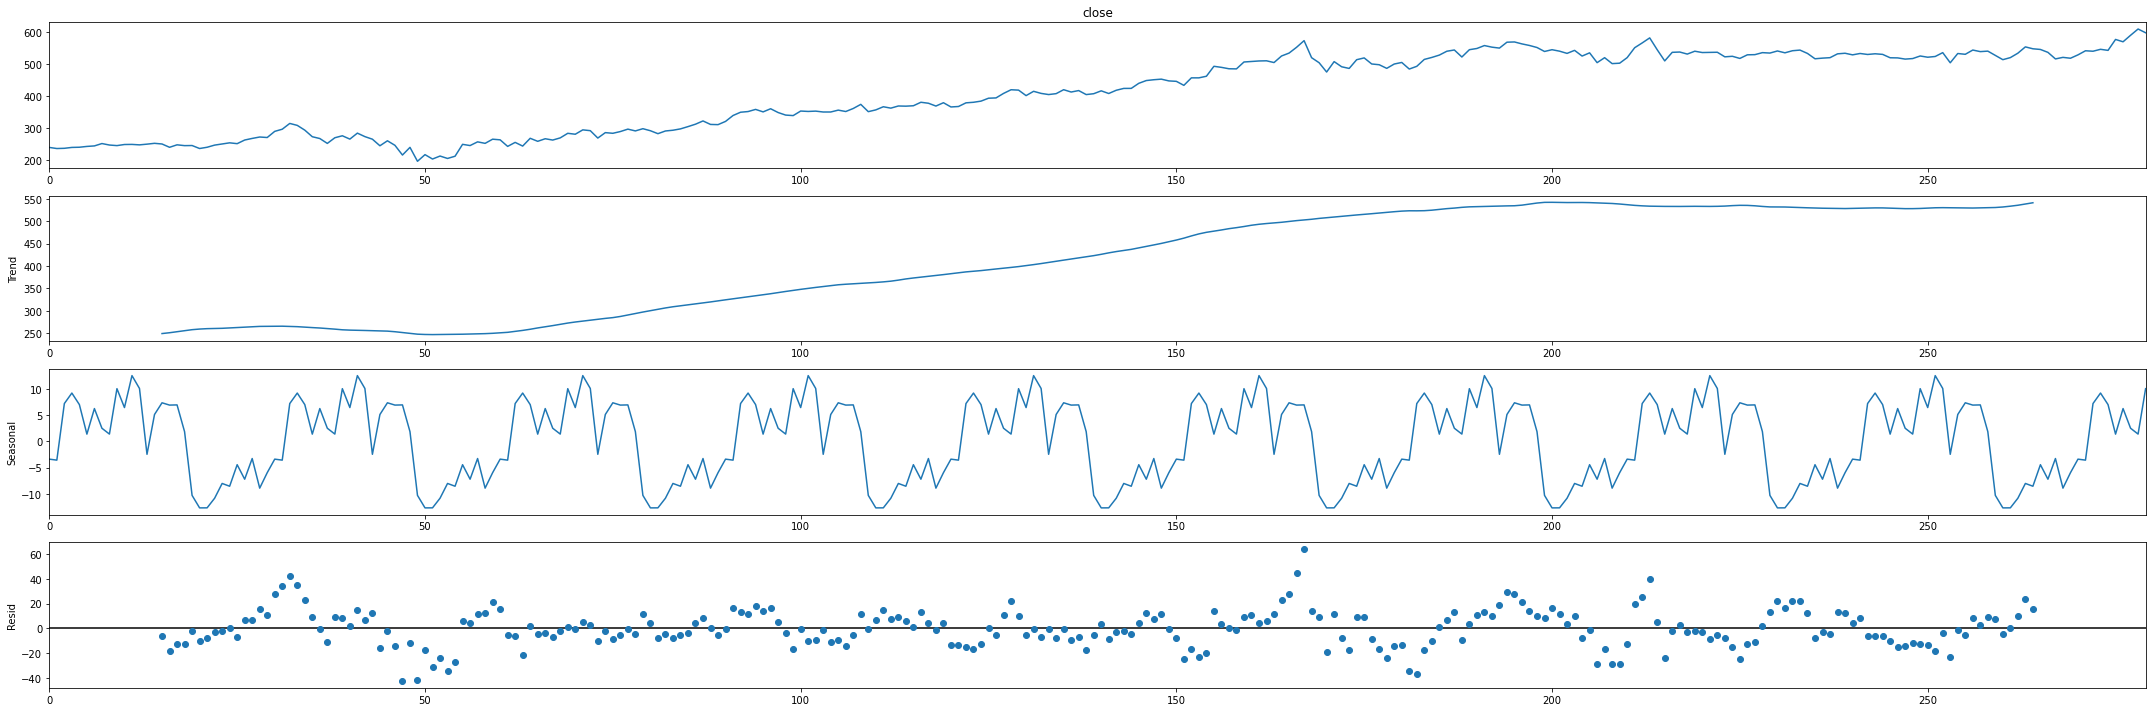

In [5]:
plt.rcParams.update({'figure.figsize': (30,10)})
sesonal_dec = seasonal_decompose(ts['close'], period=30)
sesonal_dec.plot()
plt.show()

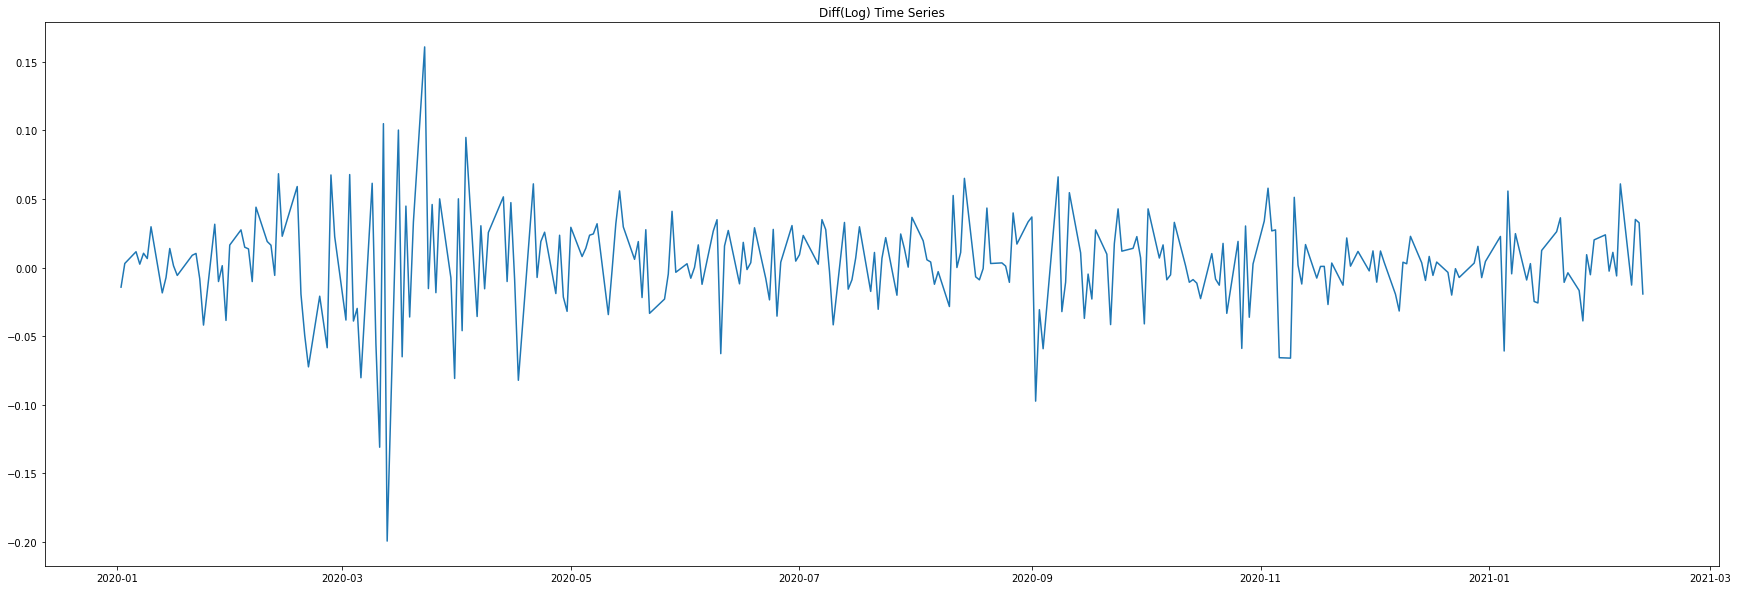

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller_statistics           -6.673431e+00
adfuller_p_value               4.527275e-09
adfuller_critical_value_1%    -3.454622e+00
adfuller_critical_value_5%    -2.872225e+00
adfuller_critical_value_10%   -2.572464e+00
kpss_statistics                8.068829e-02
kpss_p_value                   1.000000e-01
kpss_critical_value_10%        3.470000e-01
kpss_critical_value_5%         4.630000e-01
kpss_critical_value_2.5%       5.740000e-01
kpss_critical_value_1%         7.390000e-01
dtype: float64

In [6]:
processed_closed = np.log1p(ts['close']).diff(periods=1).dropna().reset_index(drop=True)

plt.title('Diff(Log) Time Series')
plt.plot(ts['date'].iloc[:-1], processed_closed)
plt.show()

processed_test_results = {}
processed_test_results.update(run_stat_test(processed_closed, adfuller))
processed_test_results.update(run_stat_test(processed_closed, kpss, 3))

pd.Series(processed_test_results)

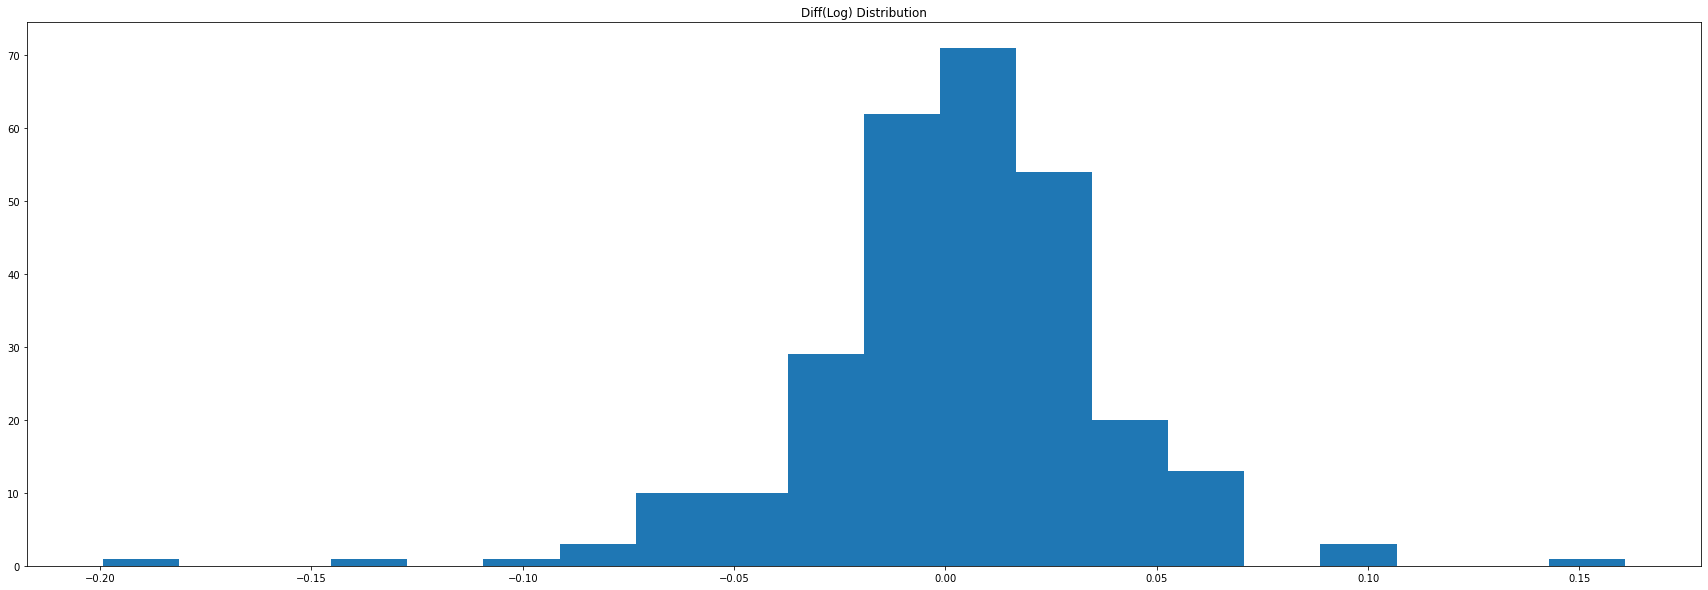

In [7]:
plt.title('Diff(Log) Distribution')
plt.hist(processed_closed, bins=20)
plt.show()

# Train/Test splitting

In [8]:
test_file_period = 7
train_file_period = ts['date'].max() - ts['date'].min()
print(f"Test file period {test_file_period}\nTrain file period {train_file_period}")

Test file period 7
Train file period 407 days 00:00:00


In [9]:
fold_ids = list(TimeSeriesSplit(test_size=test_file_period).split(ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

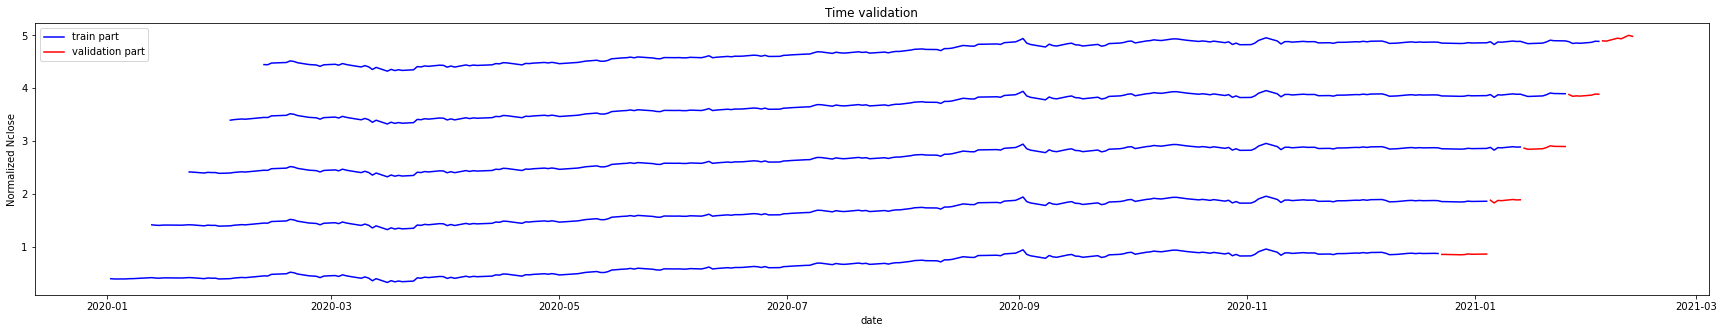

In [10]:
plot_folds(ts, fold_ids)

# ARMA

==== Fold 0 Starting
Original ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


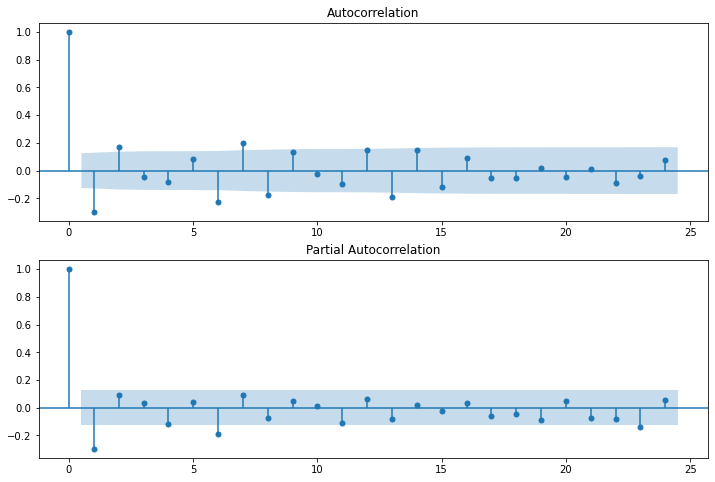

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


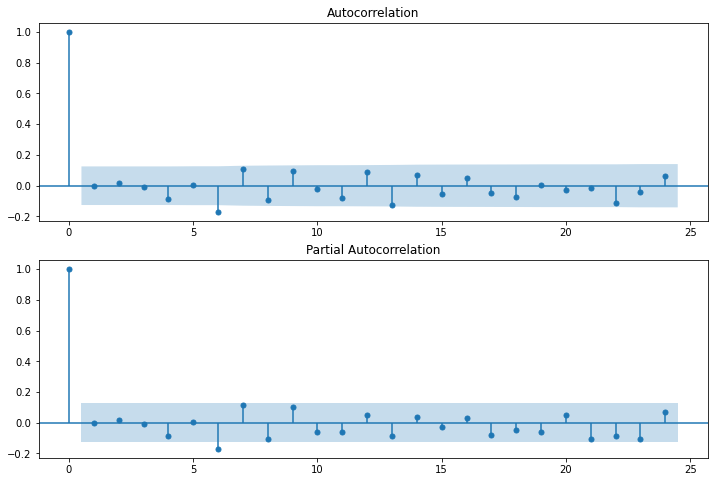

100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 487.570
Date:                Mon, 22 Mar 2021   AIC                           -965.140
Time:                        12:27:53   BIC                           -947.513
Sample:                             0   HQIC                          -958.046
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.638      0.101      -0.001       0.007
ar.L1         -0.1670      0.556     -0.300      0.764      -1.258       0.923
ar.L2          0.1222      0.157      0.779      0.4

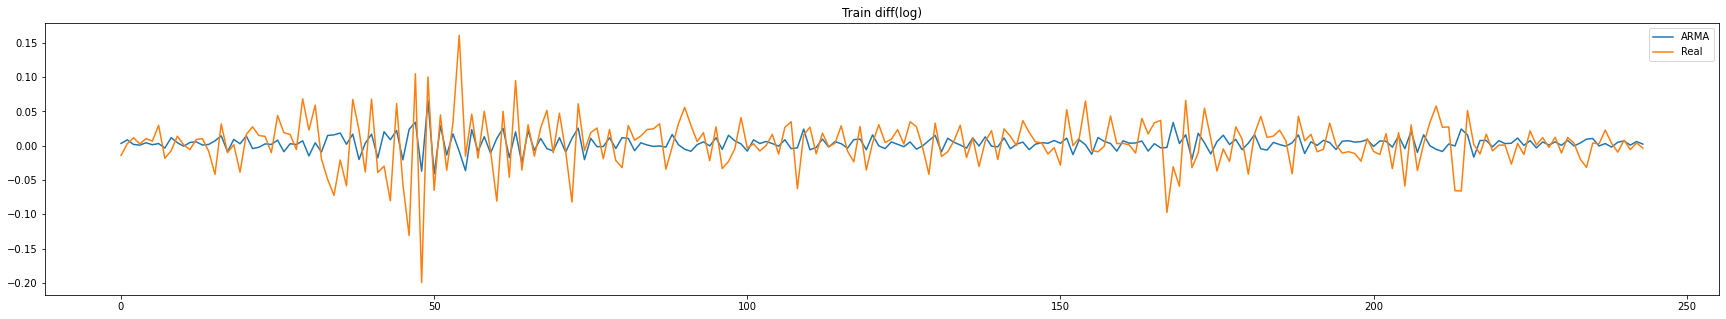

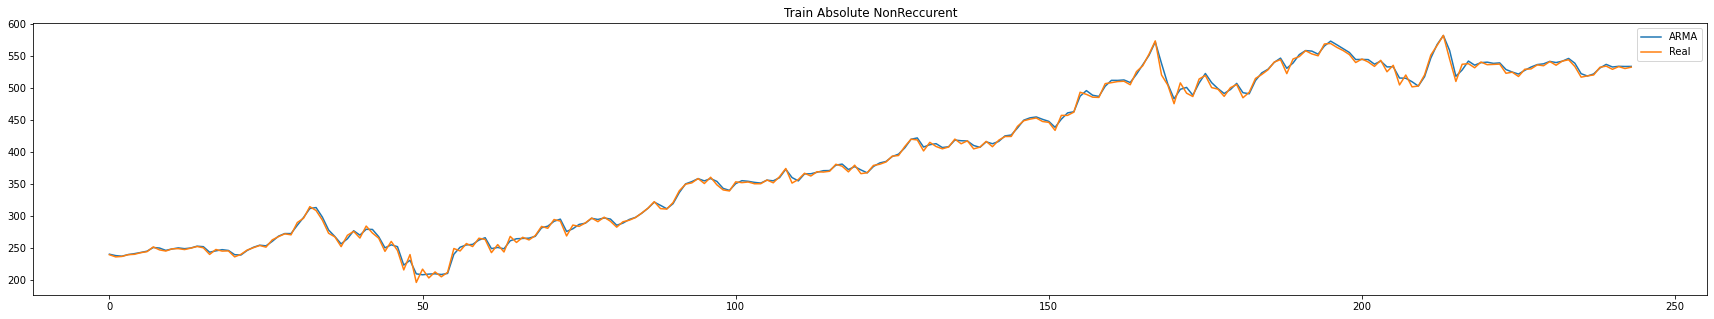

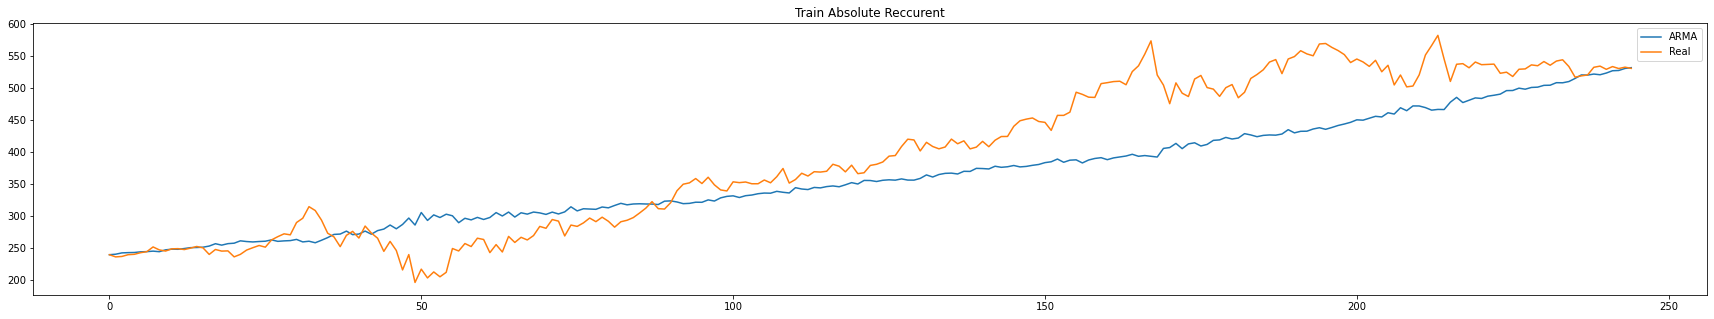

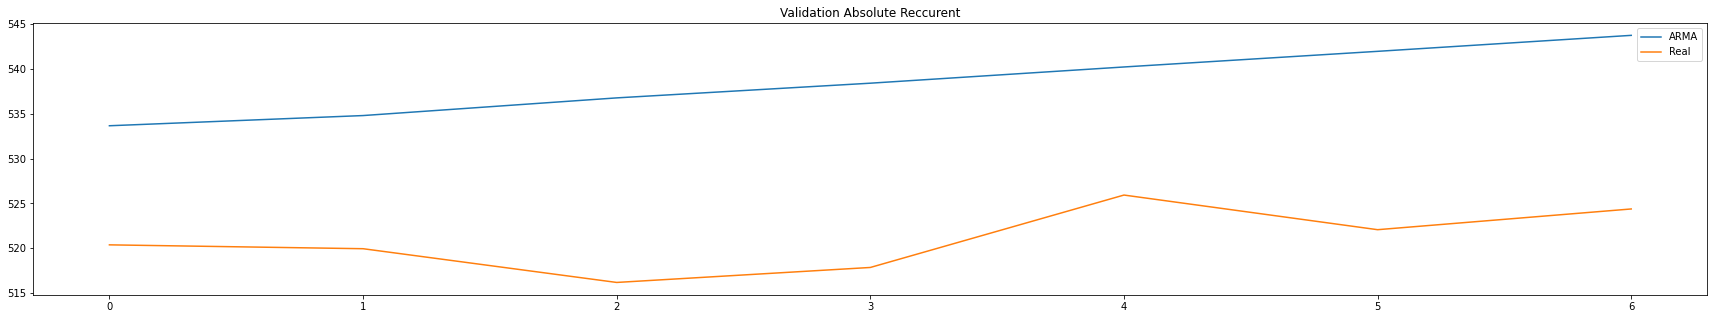

mse_train: 46.148864810089556
mse_valid: 17.532088706642007
rmse_train: 935.3288933515594
rmse_valid: 47.06033915618532
rss_train: 874840.1387382528
rss_valid: 2214.675521495189
r2_score_train: 0.44747405876176294
r2_score_valid: -25.866189718337562
durbin_watson_train: 0.00011551359492016515
durbin_watson_valid: 8.537781067034985e-06
==== Fold 0 Completed
==== Fold 1 Starting
Original ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


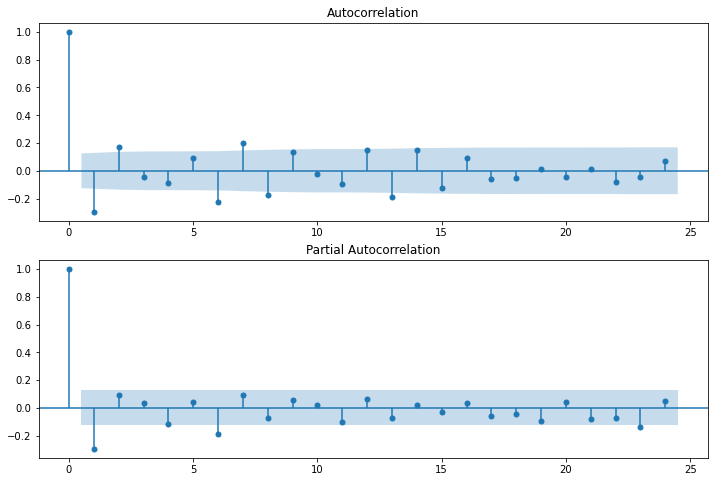

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


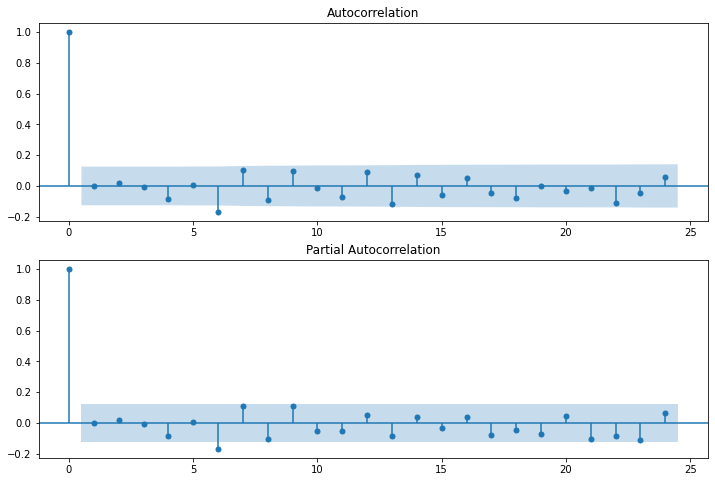

100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 487.579
Date:                Mon, 22 Mar 2021   AIC                           -965.157
Time:                        12:27:56   BIC                           -947.530
Sample:                             0   HQIC                          -958.063
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.505      0.132      -0.001       0.007
ar.L1         -0.1622      0.541     -0.300      0.764      -1.223       0.898
ar.L2          0.1252      0.152      0.824      0.4

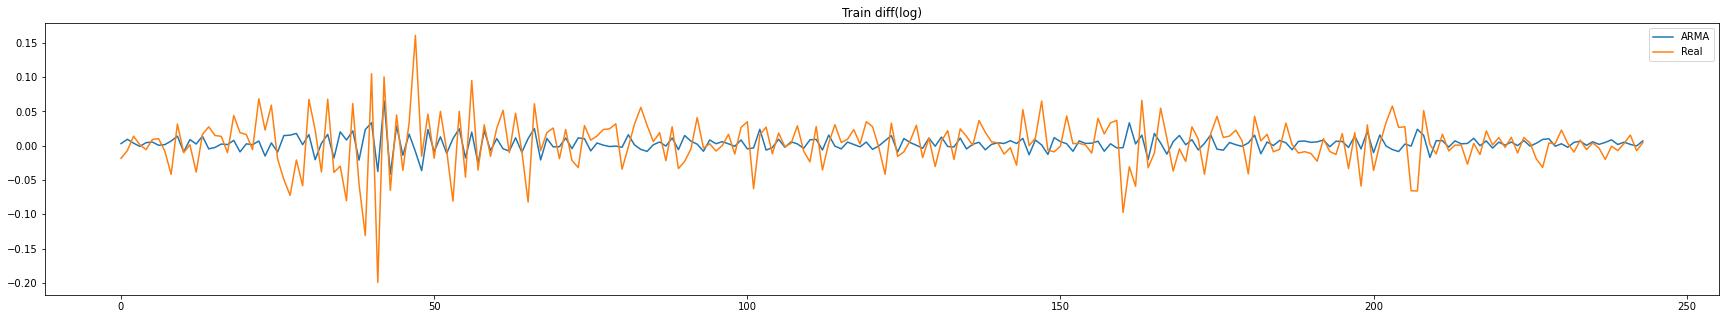

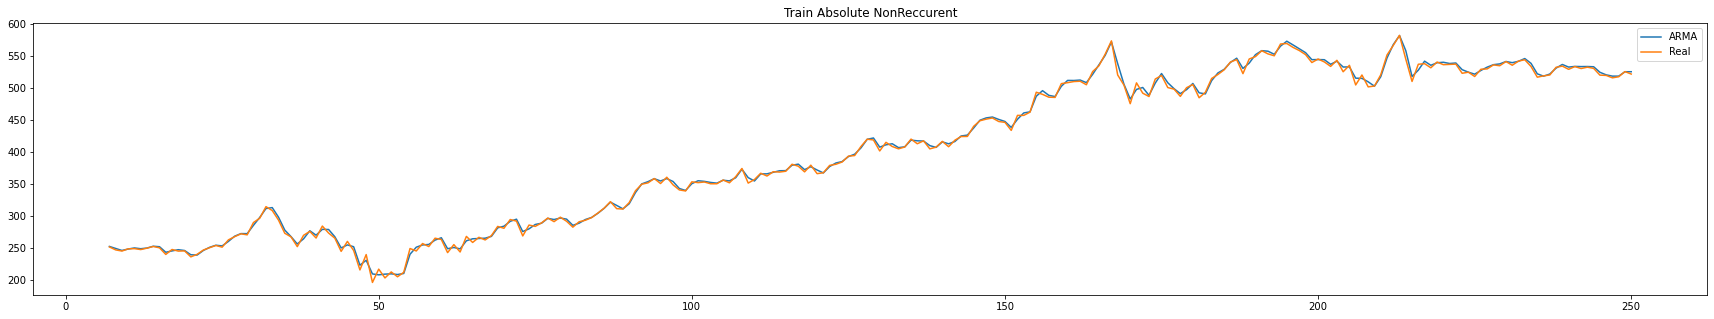

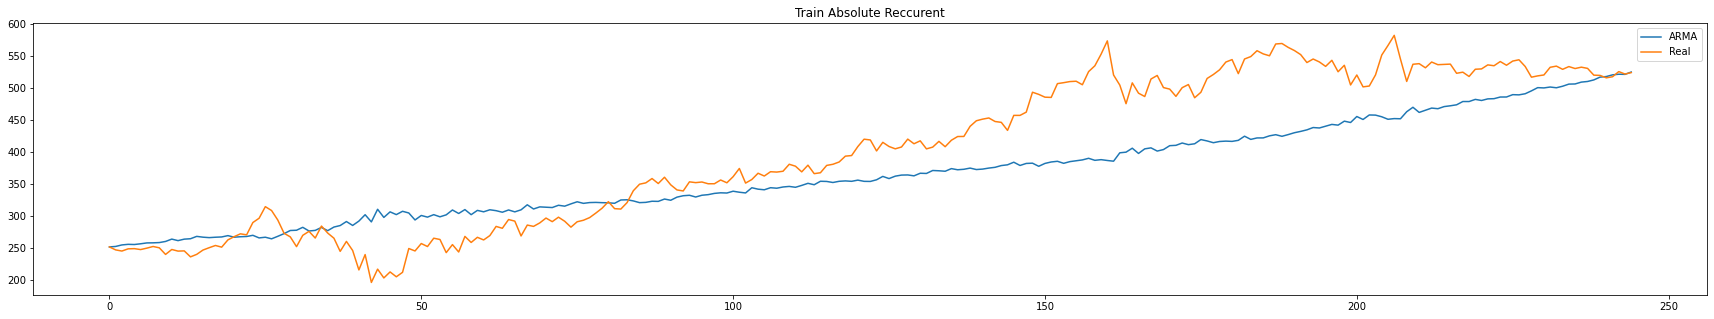

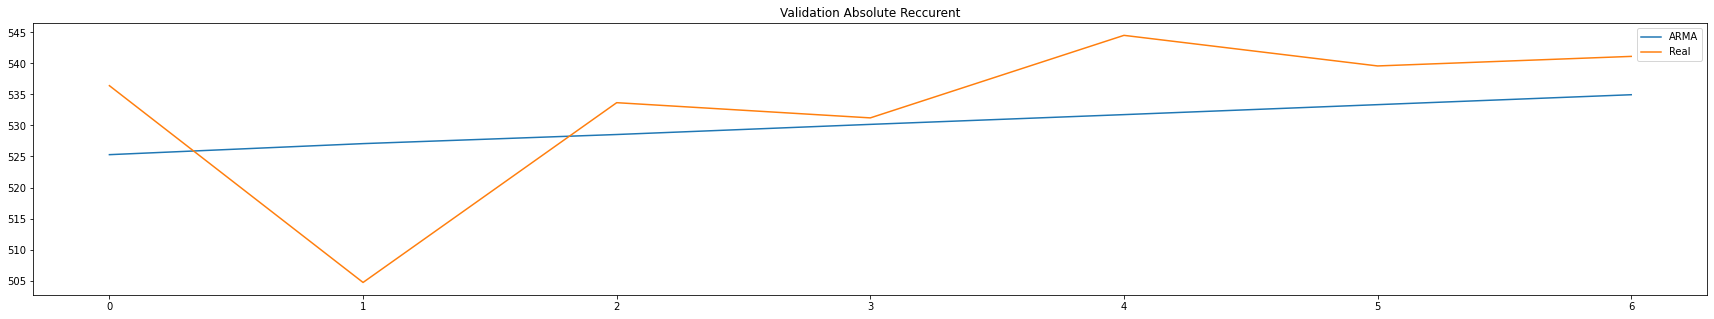

mse_train: 52.12358878856844
mse_valid: 9.265025250835338
rmse_train: 1026.8231130614513
rmse_valid: 29.86256925258773
rss_train: 1054365.70551721
rss_valid: 891.773042365598
r2_score_train: 0.2207542358940604
r2_score_valid: -11.468245772973932
durbin_watson_train: 0.00011177321194729607
durbin_watson_valid: 7.929745508015352e-06
==== Fold 1 Completed
==== Fold 2 Starting
Original ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


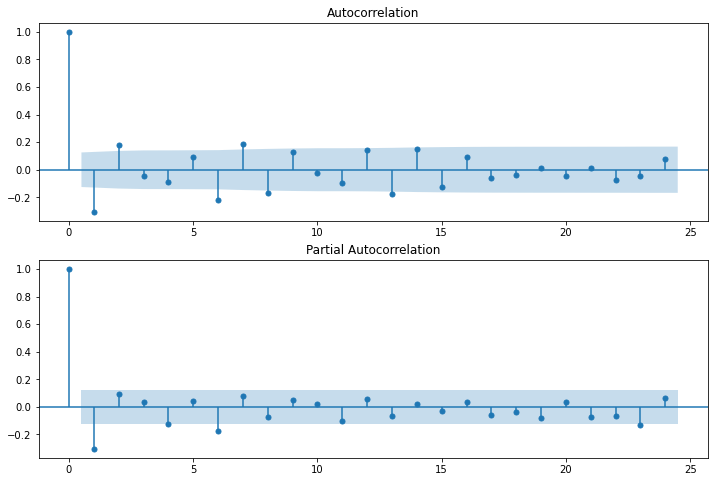

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


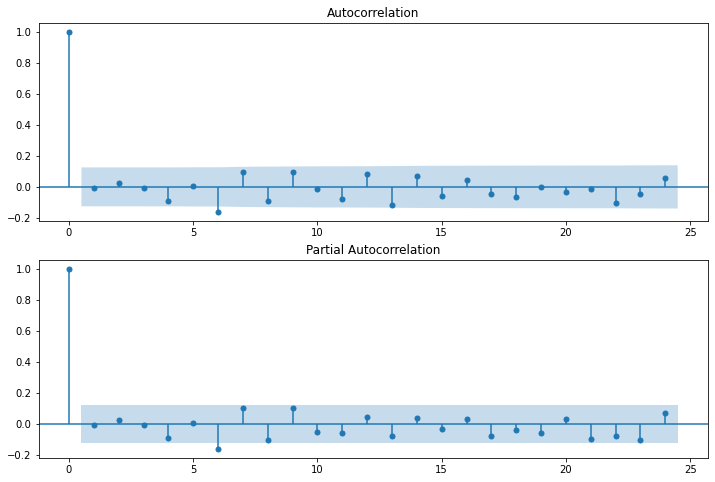

100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 485.768
Date:                Mon, 22 Mar 2021   AIC                           -961.535
Time:                        12:28:00   BIC                           -943.908
Sample:                             0   HQIC                          -954.442
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.553      0.120      -0.001       0.007
ar.L1         -0.1692      0.545     -0.311      0.756      -1.237       0.898
ar.L2          0.1275      0.157      0.812      0.4

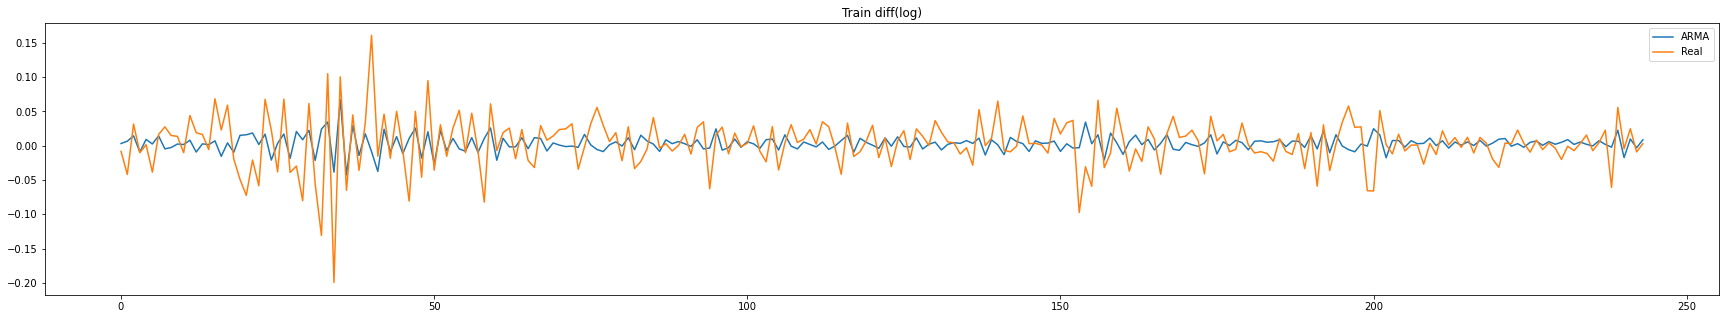

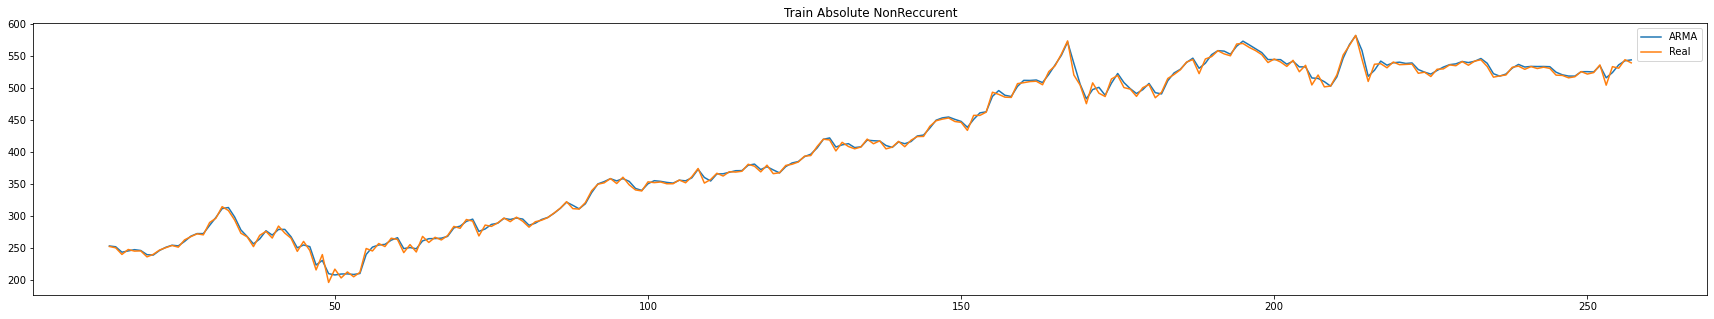

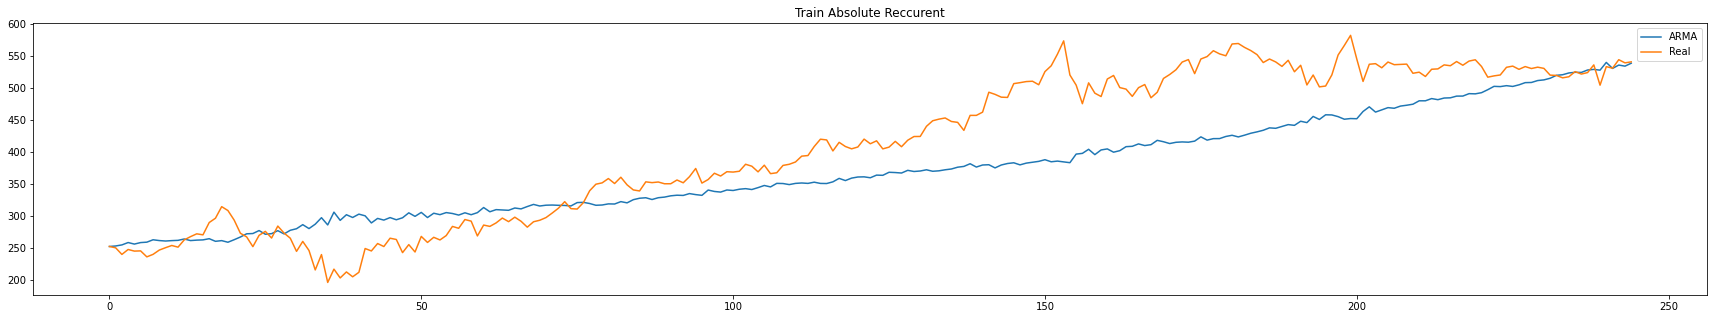

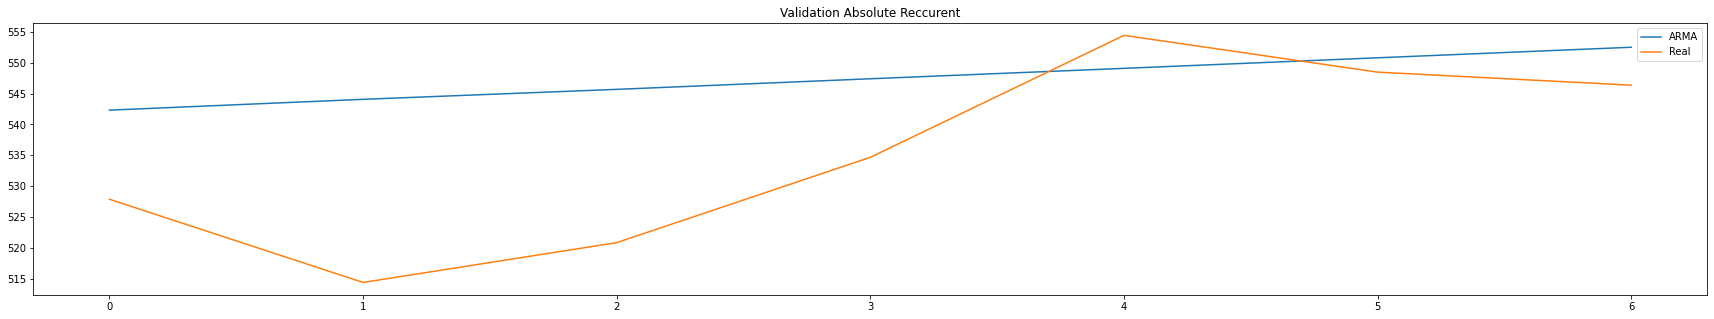

mse_train: 52.17621501659189
mse_valid: 13.638506084725204
rmse_train: 1033.5380491118908
rmse_valid: 44.029764711513664
rss_train: 1068200.8989620134
rss_valid: 1938.6201805512542
r2_score_train: 0.3010766647962734
r2_score_valid: -23.13900429329235
durbin_watson_train: 0.00011991635109453978
durbin_watson_valid: 8.249641392986066e-06
==== Fold 2 Completed
==== Fold 3 Starting
Original ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


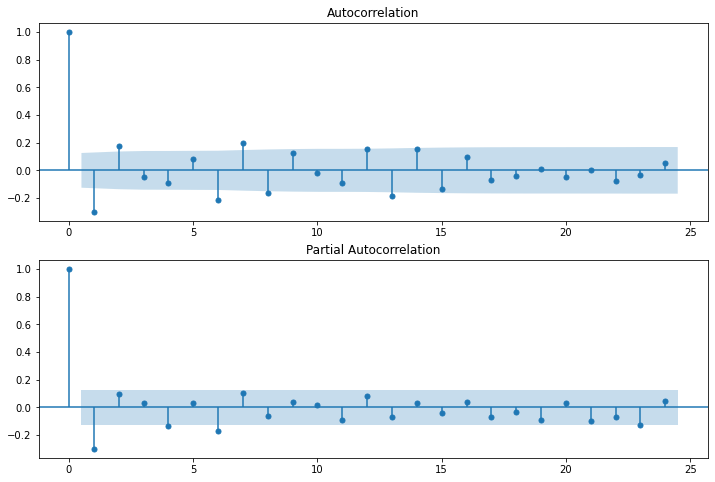

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


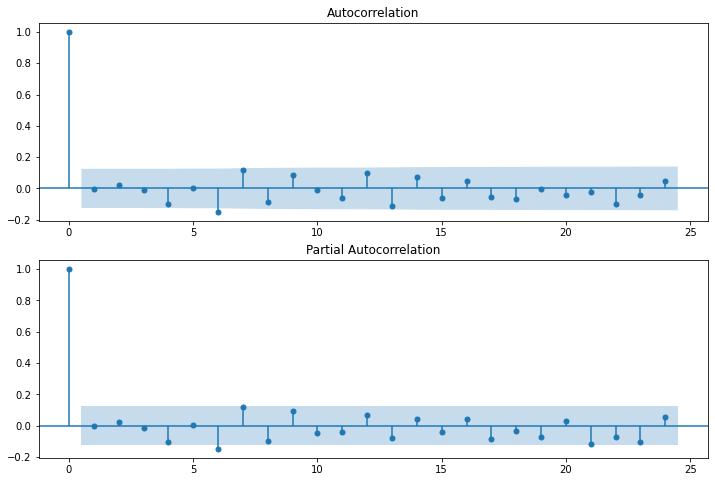

100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 485.893
Date:                Mon, 22 Mar 2021   AIC                           -961.785
Time:                        12:28:03   BIC                           -944.158
Sample:                             0   HQIC                          -954.692
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.666      0.096      -0.001       0.007
ar.L1         -0.1812      0.544     -0.333      0.739      -1.248       0.885
ar.L2          0.1231      0.155      0.794      0.4

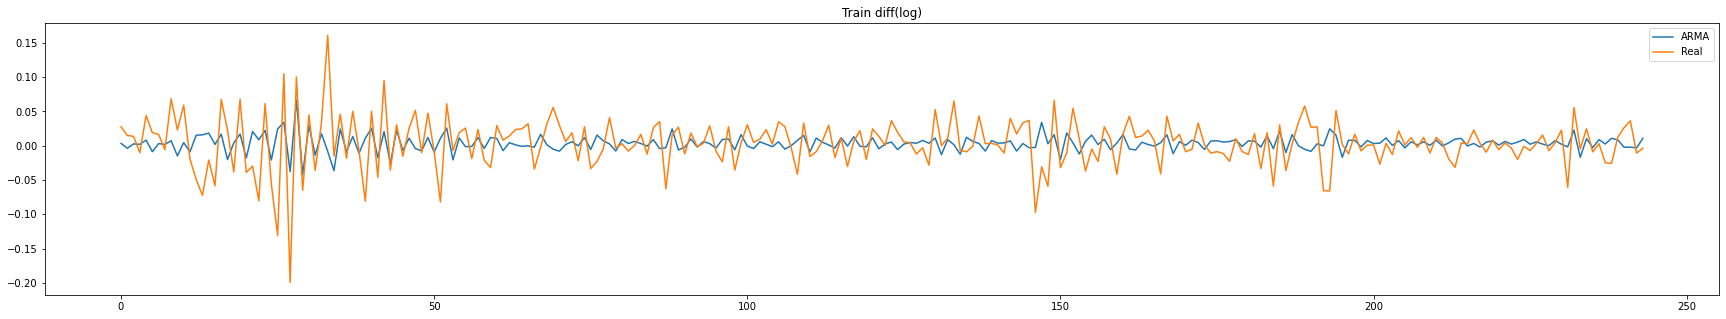

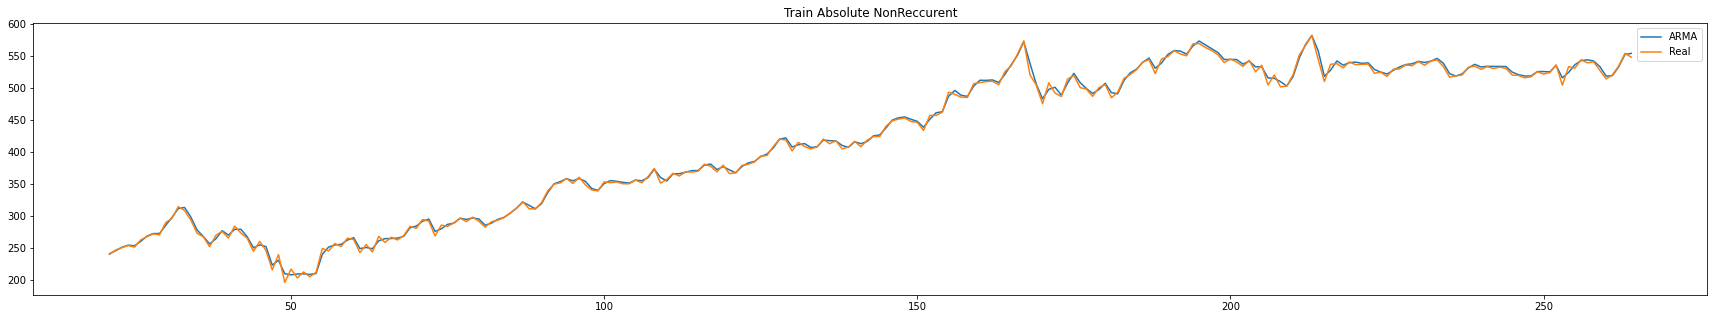

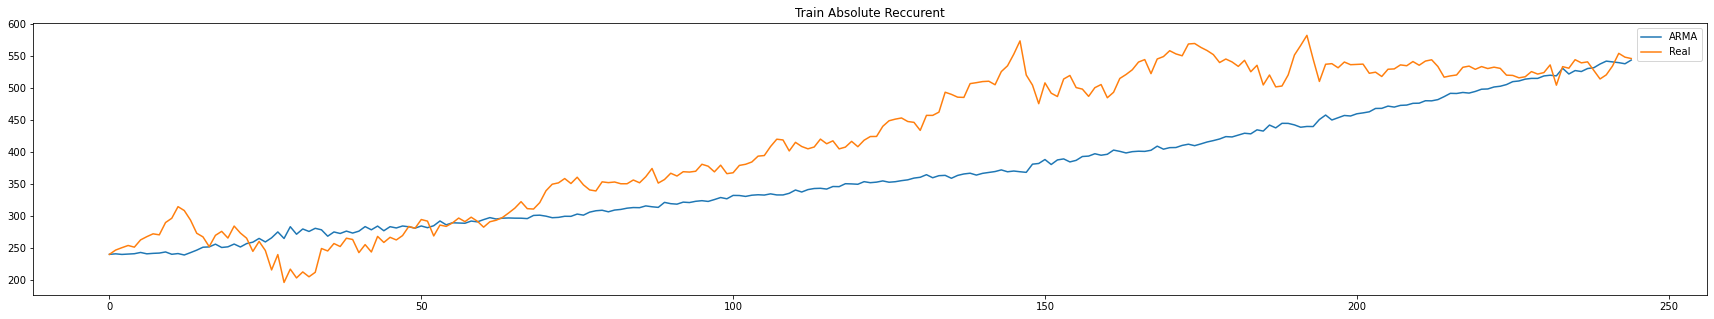

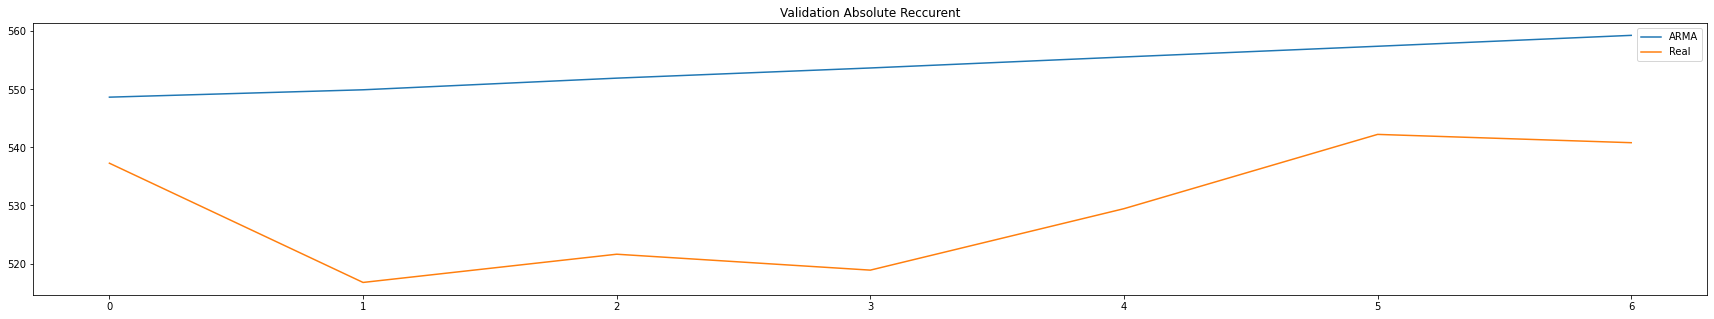

mse_train: 60.234240859456605
mse_valid: 24.20515928702142
rmse_train: 1178.5894741339407
rmse_valid: 67.92625845811212
rss_train: 1389073.1485393192
rss_valid: 4613.976588118248
r2_score_train: 0.22385263006370515
r2_score_valid: -49.44846543264736
durbin_watson_train: 0.00011218947159267075
durbin_watson_valid: 8.948823499305039e-06
==== Fold 3 Completed
==== Fold 4 Starting
Original ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


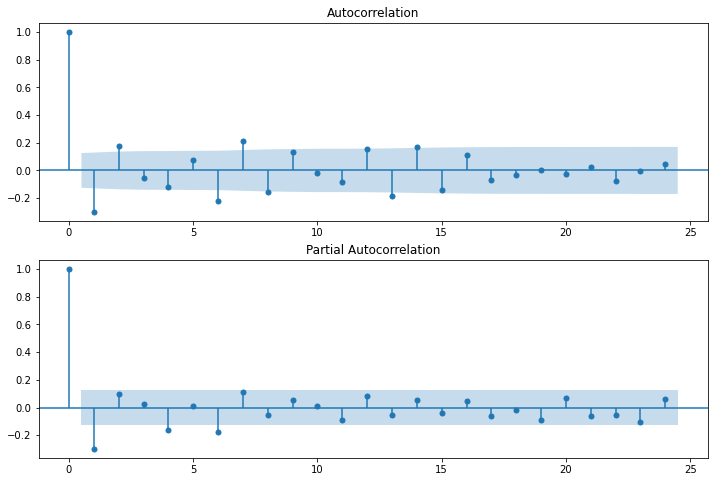

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


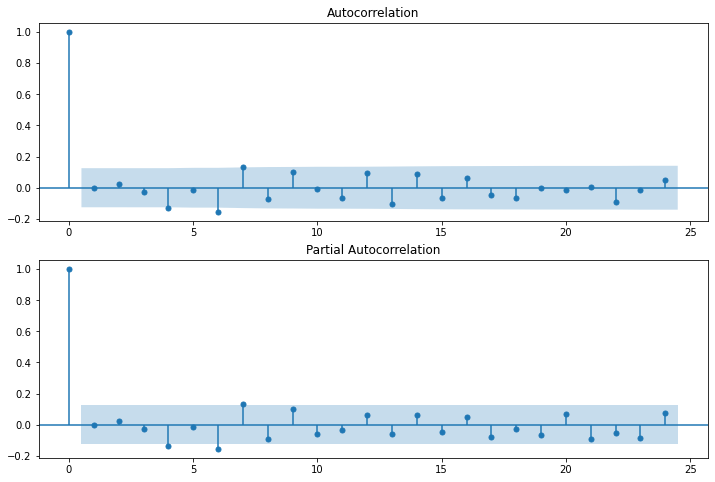

100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 485.810
Date:                Mon, 22 Mar 2021   AIC                           -961.621
Time:                        12:28:06   BIC                           -943.993
Sample:                             0   HQIC                          -954.527
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.429      0.153      -0.001       0.007
ar.L1         -0.2071      0.560     -0.370      0.712      -1.306       0.891
ar.L2          0.1143      0.160      0.714      0.4

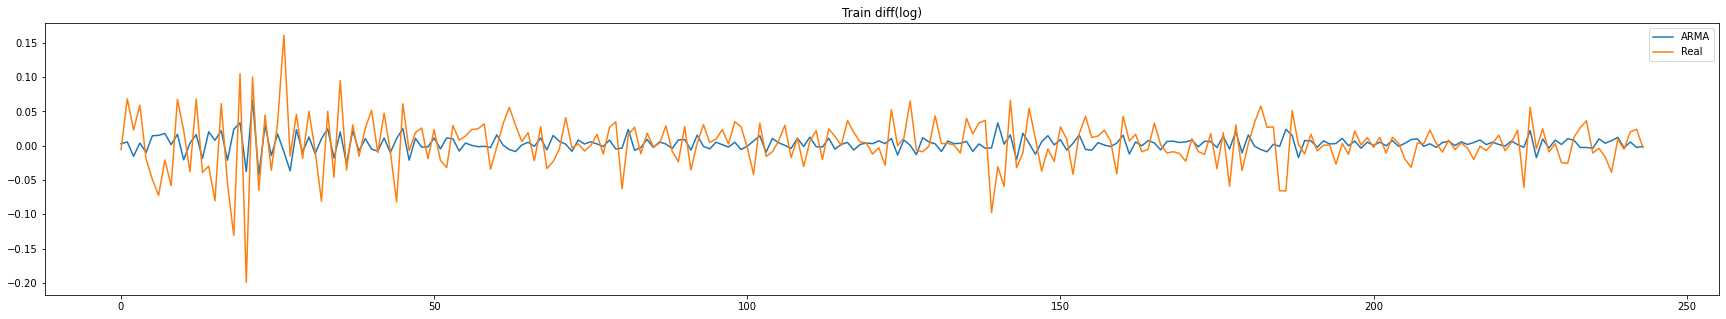

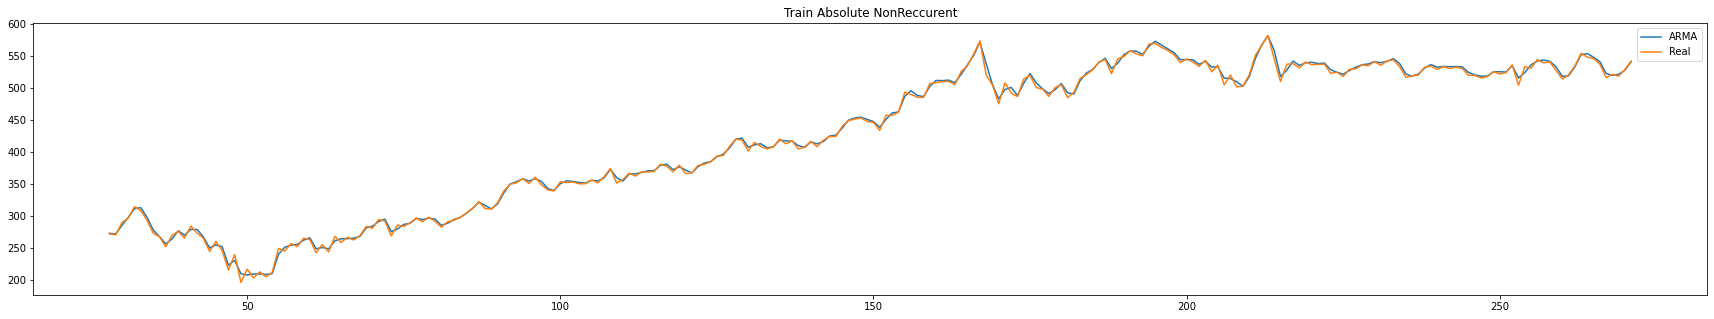

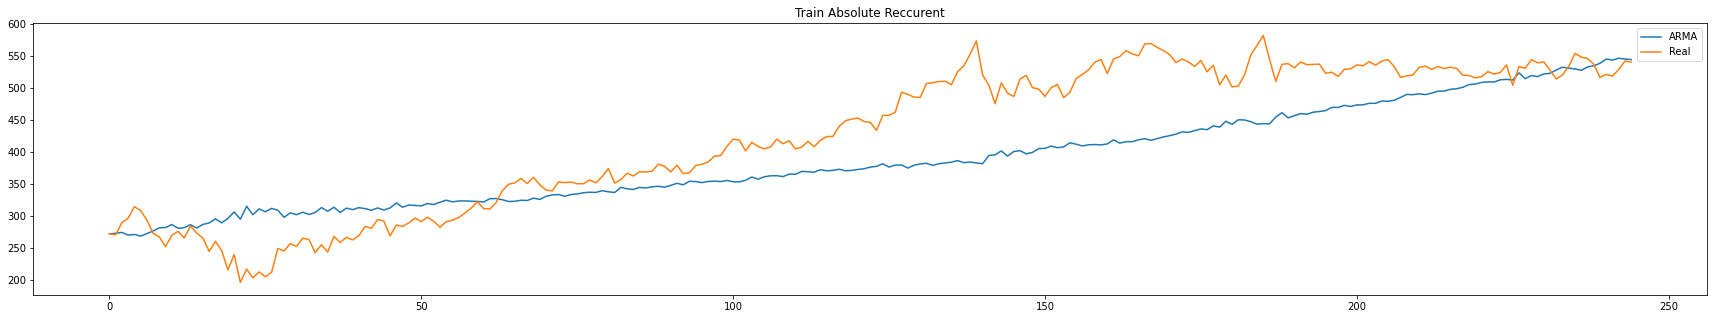

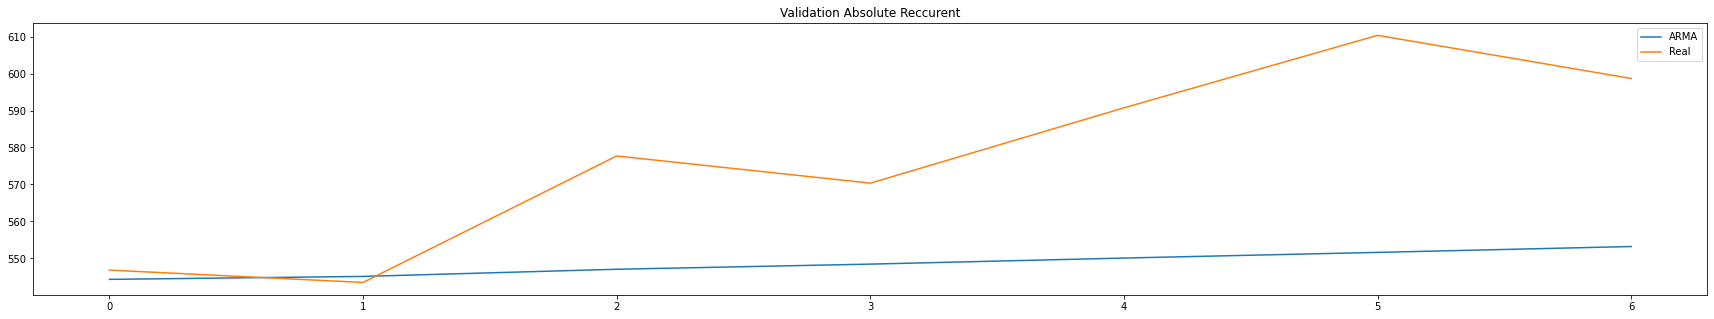

mse_train: 55.85766280881173
mse_valid: 28.783184036055168
rmse_train: 1083.4315289227843
rmse_valid: 92.69161515074607
rss_train: 1173823.8778639622
rss_valid: 8591.735519254018
r2_score_train: 0.16295842295666008
r2_score_valid: -130.46047222424357
durbin_watson_train: 0.00011058452973686674
durbin_watson_valid: 6.589455850256901e-06
==== Fold 4 Completed


In [11]:
cv_results = run_k_fold_tain_val_statmodels(
    ts, fold_ids, [(2,0,1) for _ in range(5)], 
    [
        ('mse', True, mean_absolute_error),
        ('rmse', True, rmse),
        ('rss', True, rss),
        ('r2_score', True, r2_score),
        ('durbin_watson', False, durbin_watson),
    ]
)

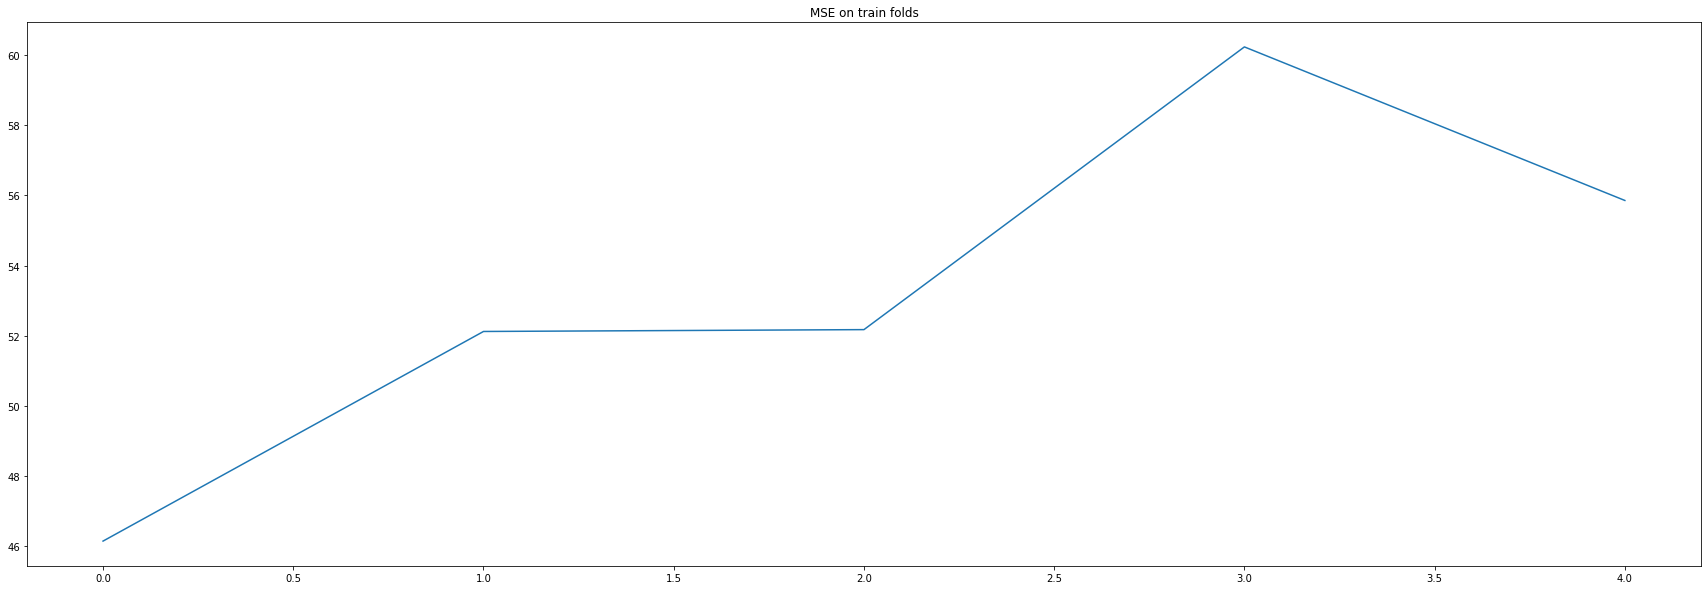

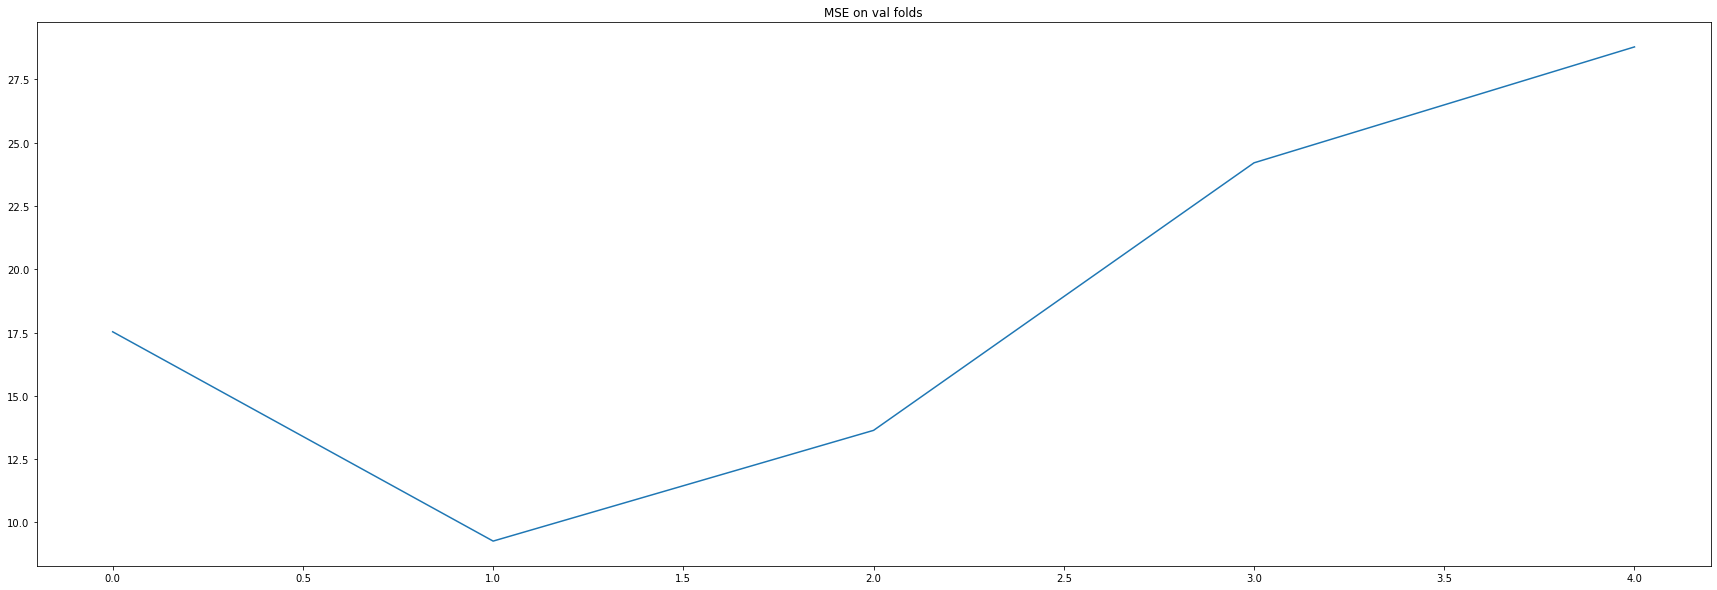

Mean Train Score: 53.30811445670364
Std Train score: 4.656405838201588
Mean Test score: 18.684792673055824
Std test score: 7.0424102227485115


In [12]:
plt.title("MSE on train folds")
plt.plot(cv_results['mse_train'])
plt.show()

plt.title("MSE on val folds")
plt.plot(cv_results['mse_valid'])
plt.show()

print("Mean Train Score: {}\nStd Train score: {}\nMean Test score: {}\nStd test score: {}".format(
    np.mean(cv_results['mse_train']),
    np.std(cv_results['mse_train']),
    np.mean(cv_results['mse_valid']),
    np.std(cv_results['mse_valid'])
))

In [ ]:
Mean Train Score: 66.11027260926491
Std Train score: 11.197176854076325
Mean Test score: 18.603814874684396
Std test score: 7.2073762570898605

    
Mean Train Score: 82.70322123718447
Std Train score: 15.179715302369376
Mean Test score: 21.22280534934827
Std test score: 8.574659212247383